In [14]:
import tensorflow as tf
from tensorflow import saved_model  
from basic_pitch import ICASSP_2022_MODEL_PATH
from tensorflow.keras.models import Model


from basic_pitch import models
from basic_pitch.callbacks import VisualizeCallback
from basic_pitch.constants import DATASET_SAMPLING_FREQUENCY
from basic_pitch.dataset import tf_example_deserialization

model = models.model(no_contours=False)



# model_path = ICASSP_2022_MODEL_PATH
model_path = "../My_models/spotify-hwd/model.best"
oldmodel = saved_model.load(str(model_path))
weights = oldmodel.variables
model.set_weights(weights)

# Ora puoi fare una predizione su un dato input


In [19]:
import tensorflow as tf
import numpy as np
import librosa
import os


from basic_pitch.constants import (
    AUDIO_SAMPLE_RATE,
    AUDIO_N_SAMPLES,
    ANNOTATIONS_FPS,
    FFT_HOP,
)

def window_audio_file(audio_original, hop_size):
    """
    Pad appropriately an audio file, and return as
    windowed signal, with window length = AUDIO_N_SAMPLES

    Returns
    -------
    audio_windowed: tensor with shape (n_windows, AUDIO_N_SAMPLES, 1)
        audio windowed into fixed length chunks
    window_times: list of {'start':.., 'end':...} objects (times in seconds)

    """

    # create a tensor with shape (n_windows, sample_one_window, 1) where window size is AUDIO_N_SAMPLES
    audio_windowed = tf.expand_dims(
        tf.signal.frame(audio_original, AUDIO_N_SAMPLES, hop_size, pad_end=True, pad_value=0),
        axis=-1,
    )

    # create a list of dictionaries with start and end times of each window
    window_times = [
        {
            "start": t_start,
            "end": t_start + (AUDIO_N_SAMPLES / AUDIO_SAMPLE_RATE),
        }
        for t_start in np.arange(audio_windowed.shape[0]) * hop_size / AUDIO_SAMPLE_RATE
    ]
    return audio_windowed, window_times

def get_audio_input(audio_path, overlap_len, hop_size):
    """
    Read wav file (as mono), pad appropriately, and return as
    windowed signal, with window length = AUDIO_N_SAMPLES

    Returns
    -------
    audio_windowed: tensor with shape (n_windows, AUDIO_N_SAMPLES, 1)
        audio windowed into fixed length chunks
    window_times: list of {'start':.., 'end':...} objects (times in seconds)
    audio_original_length: int
        length of original audio file, in frames, BEFORE padding.

    """
    assert overlap_len % 2 == 0, "overlap_length must be even, got {}".format(overlap_len)

    #load audio file and get original length
    audio_original, _ = librosa.load(audio_path, sr=AUDIO_SAMPLE_RATE, mono=True)
    original_length = audio_original.shape[0]

    # pad audio with zeros at the beginning
    audio_original = np.concatenate([np.zeros((int(overlap_len / 2),), dtype=np.float32), audio_original])

    # pad audio with zeros at the end and divide into windows
    audio_windowed, window_times = window_audio_file(audio_original, hop_size)

    return audio_windowed, window_times, original_length

def unwrap_output(output, audio_original_length, n_overlapping_frames):
    """Unwrap batched model predictions to a single matrix.

    Parameters:
        output : array (n_batches, n_times_short, n_freqs)
        audio_original_length : length of original audio signal (in samples)
        n_overlapping_frames : number of overlapping frames in the output

    Return:
        array (n_times, n_freqs)
    """
    
    # check of dimensions
    raw_output = output.numpy()
    if len(raw_output.shape) != 3:
        return None

    # remove half of the overlapping frames from beginning and end
    n_olap = int(0.5 * n_overlapping_frames)
    if n_olap > 0:
        raw_output = raw_output[:, n_olap:-n_olap, :]
    output_shape = raw_output.shape

    # compute number of output timeframes in the original audio
    n_output_frames_original = int(np.floor(audio_original_length * (ANNOTATIONS_FPS / AUDIO_SAMPLE_RATE)))
    
    # reshape to (n_times, n_freqs) and trim to original audio length (paste together batches)
    unwrapped_output = raw_output.reshape(output_shape[0] * output_shape[1], output_shape[2])
    return unwrapped_output[:n_output_frames_original, :] 


def run_inference(audio_path, model):
    n_overlapping_frames = 30 # number of overlapping frames
    overlap_len = n_overlapping_frames * FFT_HOP # number of samples in the overlapping region
    hop_size = AUDIO_N_SAMPLES - overlap_len # hop size for the audio windows

    # get audio input and divide into windows
    audio_windowed, _, audio_original_length = get_audio_input(audio_path, overlap_len, hop_size)

    # predict
    output = model(audio_windowed)
    
    # unwrap output to a single matrix for eache output key (note, onset, contour)
    unwrapped_output = {k: unwrap_output(output[k], audio_original_length, n_overlapping_frames) for k in output}
    return unwrapped_output


audio_path = os.path.join(os.path.expanduser('~'),'mir_datasets','hwd','MLEndHWD_Frozen_Audio_Files', '5798.wav')

outputs = run_inference(audio_path, model)

In [21]:
import numpy as np
np.set_printoptions(threshold=np.inf)

with open('Intemediate_outputs.txt', 'w') as f:
    for output in outputs.values():
        f.write(f"{output}\n")

In [109]:
import pandas as pd
import json
from typing import Dict, List, Tuple
from IPython.display import display

import os


benchmark = pd.read_json("./saved_models/icassp_2022/model.best.json",orient='index')

guitarset_b = benchmark[benchmark.index.str[0].str.isnumeric()]
slakh_b = benchmark[benchmark.index.str.startswith('Track')]
hwd_b = benchmark[~benchmark.index.str[0].str.isnumeric() & ~benchmark.index.str.startswith('Track')]

display(guitarset_b.describe())
display(slakh_b.describe())
display(hwd_b.describe())

,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.547995,0.538603,0.538590,0.880674,0.796781,0.774948,0.777741,0.777782,0.834605,0.811038,0.814197,0.736634,0.714199,0.717496
std,0.123860,0.144330,0.128643,0.026965,0.095202,0.112228,0.076952,0.045692,0.087579,0.103467,0.059728,0.095766,0.097799,0.064758
min,0.338415,0.161103,0.218289,0.821399,0.626087,0.417997,0.566372,0.651982,0.660870,0.458636,0.621436,0.547826,0.451379,0.611603
25%,0.444096,0.447808,0.438965,0.863377,0.719571,0.729947,0.726835,0.743653,0.783171,0.754979,0.782828,0.659780,0.657601,0.665437
50%,0.554217,0.500000,0.533333,0.883062,0.811594,0.777174,0.768166,0.781781,0.824561,0.836158,0.823529,0.732704,0.720621,0.709220
75%,0.648172,0.641371,0.648450,0.892630,0.880201,0.851397,0.848098,0.812954,0.906929,0.868826,0.857738,0.804061,0.781746,0.779724
max,0.768116,0.868852,0.815385,0.929934,0.942529,0.937500,0.900585,0.854030,0.963415,0.947917,0.905797,0.948171,0.901639,0.846154


,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,0.161878,0.225239,0.177375,0.609104,0.354362,0.514583,0.388185,0.455876,0.430439,0.644749,0.475869,0.372768,0.688829,0.434545
std,0.196700,0.262113,0.209038,0.398761,0.309484,0.384265,0.307876,0.292042,0.327634,0.347901,0.312191,0.222328,0.257464,0.199832
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008929,0.042654,0.014766,0.044890,0.056424,0.050000
25%,0.000000,0.000000,0.000000,0.000000,0.027439,0.101124,0.043165,0.263559,0.060976,0.377327,0.095923,0.205357,0.616401,0.307692
50%,0.050000,0.152284,0.076923,0.843256,0.332011,0.500000,0.459983,0.502433,0.464286,0.811111,0.539299,0.307407,0.750000,0.404381
75%,0.343831,0.352941,0.367811,0.887445,0.600707,0.874594,0.626263,0.743501,0.748737,0.948649,0.700611,0.586281,0.864583,0.635438
max,0.573099,0.797909,0.588589,0.926148,0.927966,1.000000,0.883846,0.850184,0.957797,1.000000,0.899468,0.766082,1.000000,0.786787


,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,651.0,651.0,651.0,651.0,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000
mean,0.0,0.0,0.0,0.0,0.000042,0.000040,0.000041,0.000757,0.193748,0.184304,0.169361,0.287866,0.273198,0.251630
std,0.0,0.0,0.0,0.0,0.001059,0.001031,0.001045,0.019320,0.105315,0.117085,0.093802,0.130791,0.149672,0.116133
min,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.121831,0.092215,0.100360,0.217787,0.160000,0.166667
50%,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.194444,0.175000,0.166667,0.292683,0.270270,0.259740
75%,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.266667,0.268762,0.236068,0.371761,0.392857,0.337662
max,0.0,0.0,0.0,0.0,0.027027,0.026316,0.026667,0.492954,0.666667,0.600000,0.441558,1.000000,0.692308,0.526316


<Axes: title={'center': 'HWD'}>

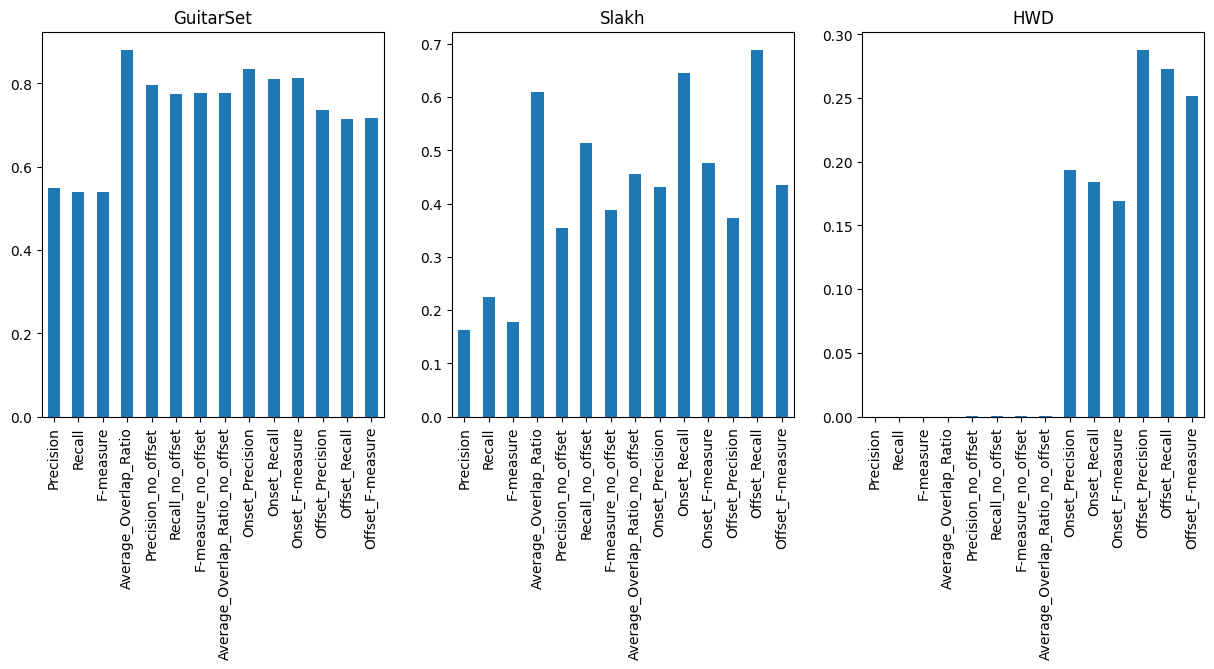

In [110]:
#plot the precision recall f-measure score for each dataset taking into account only the mean
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 3, figsize=(15, 5))

guitarset_b.describe().loc['mean'].plot(kind='bar', ax=ax[0], title='GuitarSet')
slakh_b.describe().loc['mean'].plot(kind='bar', ax=ax[1], title='Slakh')
hwd_b.describe().loc['mean'].plot(kind='bar', ax=ax[2], title='HWD')


In [111]:



# load all the json files in my_models
def load_json_files(path):

    data = pd.DataFrame()
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith('.json'):
                with open(os.path.join(root, file)) as f:
                    data=pd.concat([data,pd.read_json(f, orient='index')])
    return data


data= load_json_files('../My_models')
data

,instrument,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
Potter_Whistle_160_0004,whistle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Potter_Whistle_213_0008,whistle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.032258,0.062500
Potter_Hum_11_0013,hum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.187500,0.111111,0.139535,0.500000,0.296296,0.372093
Potter_Hum_198_0021,hum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.230769,0.206897,0.218182,0.346154,0.310345,0.327273
Potter_Hum_82_0025,hum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294118,0.172414,0.217391,0.294118,0.172414,0.217391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Track00013-S06,Synth Lead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Track00015-S03,Strings (continued),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Track00016-S00,Piano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Track00016-S02,Guitar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
data.describe()

,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000,2188.000000
mean,0.023676,0.017448,0.019493,0.052825,0.043658,0.029137,0.033313,0.041202,0.225819,0.124363,0.145511,0.335903,0.190251,0.218375
std,0.106736,0.083494,0.090818,0.206310,0.175559,0.123053,0.137355,0.161989,0.210310,0.133109,0.145171,0.212792,0.152685,0.153544
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.040000,0.057143,0.200000,0.084906,0.114637
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.185185,0.100000,0.117647,0.318182,0.160000,0.200000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.297222,0.160000,0.189128,0.428571,0.265196,0.292683
max,0.822222,0.666667,0.698113,0.957266,1.000000,0.833333,0.844037,0.957266,1.000000,0.843206,0.844037,1.000000,0.971564,0.833333


In [113]:
guitarset = data[data.index.str[0].str.isnumeric()]
slakh = data[data.index.str.startswith('Track')]
hwd = data[~data.index.str[0].str.isnumeric() & ~data.index.str.startswith('Track')]

display(guitarset.describe())
display(slakh.describe())
display(hwd.describe())

,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,0.428607,0.287210,0.338348,0.850681,0.778759,0.474388,0.573447,0.648037,0.834947,0.501627,0.608436,0.809589,0.477374,0.581642
std,0.203018,0.181853,0.195020,0.028244,0.107098,0.181941,0.174679,0.125291,0.075384,0.174577,0.160329,0.088523,0.154010,0.136380
min,0.030928,0.004354,0.007634,0.774321,0.550725,0.085631,0.150127,0.285905,0.673077,0.103048,0.180662,0.594203,0.130624,0.229008
25%,0.246914,0.115789,0.183333,0.830523,0.710526,0.347280,0.449848,0.595819,0.790210,0.378049,0.519403,0.750000,0.384921,0.508021
50%,0.450000,0.282609,0.340836,0.849022,0.780000,0.524752,0.614583,0.673010,0.833333,0.548913,0.645833,0.822034,0.495726,0.588235
75%,0.588235,0.415842,0.512397,0.869648,0.855670,0.620253,0.710744,0.737014,0.884058,0.635417,0.730897,0.870968,0.609375,0.682353
max,0.822222,0.606557,0.698113,0.916411,1.000000,0.755814,0.844037,0.832394,1.000000,0.767442,0.844037,0.961538,0.738739,0.811321


,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,0.189549,0.181996,0.177525,0.578851,0.366666,0.311639,0.310465,0.474309,0.440670,0.369780,0.368783,0.573354,0.587153,0.548273
std,0.220047,0.224026,0.210167,0.415620,0.301864,0.280559,0.261110,0.322030,0.327004,0.292820,0.271810,0.211344,0.268633,0.214795
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124579,0.032118,0.051070
25%,0.000000,0.000000,0.000000,0.000000,0.032075,0.031818,0.031545,0.156033,0.077141,0.069693,0.072838,0.456136,0.437185,0.456917
50%,0.045351,0.043750,0.044118,0.857301,0.378753,0.250114,0.294558,0.464658,0.482323,0.333333,0.358333,0.631724,0.670270,0.610526
75%,0.380443,0.335586,0.330729,0.889066,0.606602,0.566742,0.568882,0.767108,0.724723,0.614682,0.619190,0.712016,0.799652,0.700376
max,0.666667,0.666667,0.666667,0.957266,0.992248,0.833333,0.833333,0.957266,1.000000,0.843206,0.833333,1.000000,0.971564,0.833333


,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,2032.0,2032.0,2032.0,2032.0,2032.0,2032.0,2032.0,2032.0,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.191279,0.099487,0.117402,0.306861,0.164805,0.191522
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.156494,0.077951,0.084404,0.184858,0.111879,0.113999
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.037037,0.054054,0.190476,0.080000,0.109091
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.176471,0.093023,0.111111,0.307692,0.153846,0.185450
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272727,0.153846,0.173913,0.400000,0.241379,0.272727
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.500000,0.483871,1.000000,0.538462,0.564103


<Axes: title={'center': 'HWD'}>

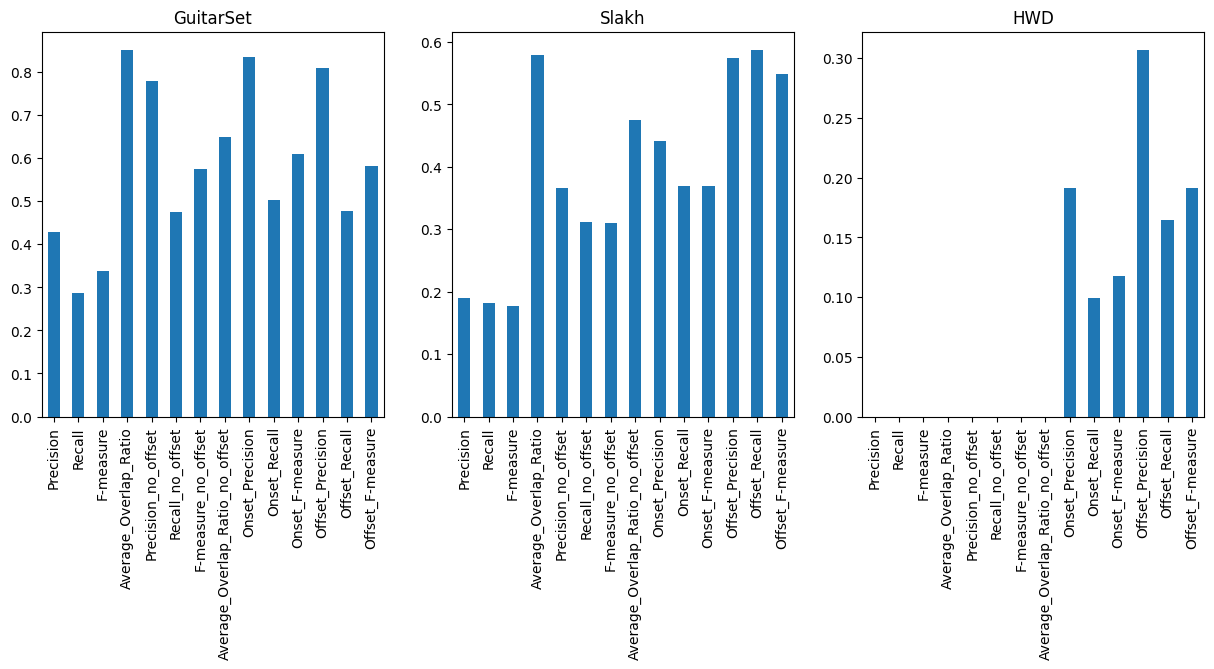

In [114]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

guitarset.describe().loc['mean'].plot(kind='bar', ax=ax[0], title='GuitarSet')
slakh.describe().loc['mean'].plot(kind='bar', ax=ax[1], title='Slakh')
hwd.describe().loc['mean'].plot(kind='bar', ax=ax[2], title='HWD')

<Axes: title={'center': 'Difference'}>

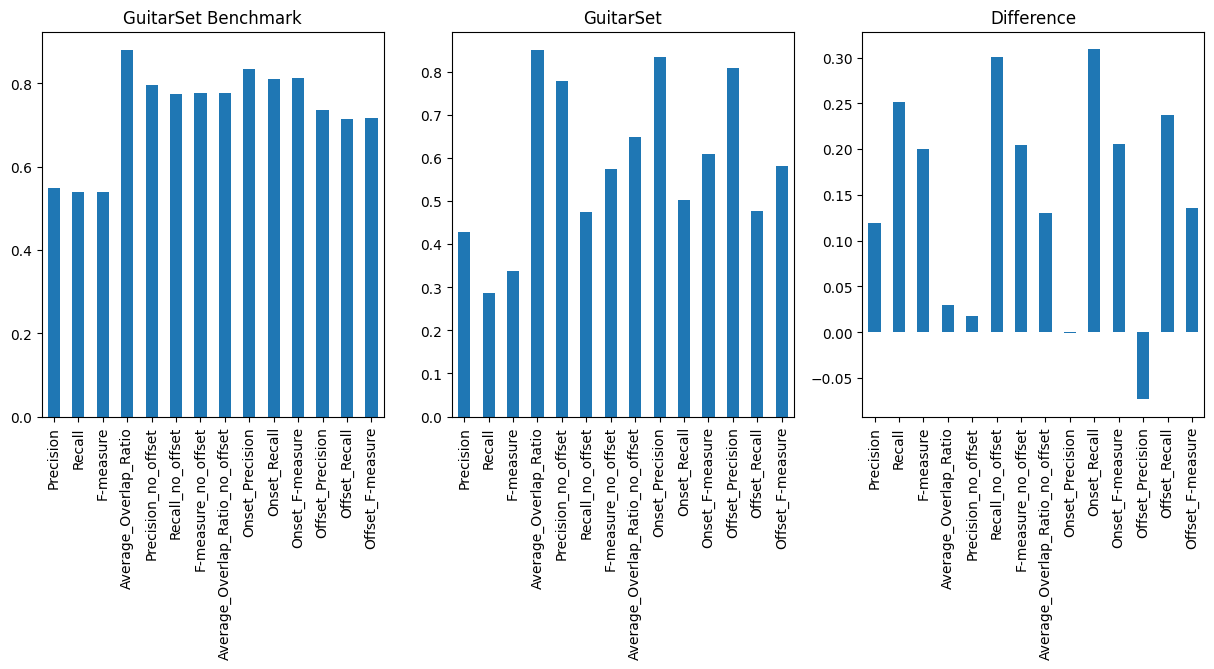

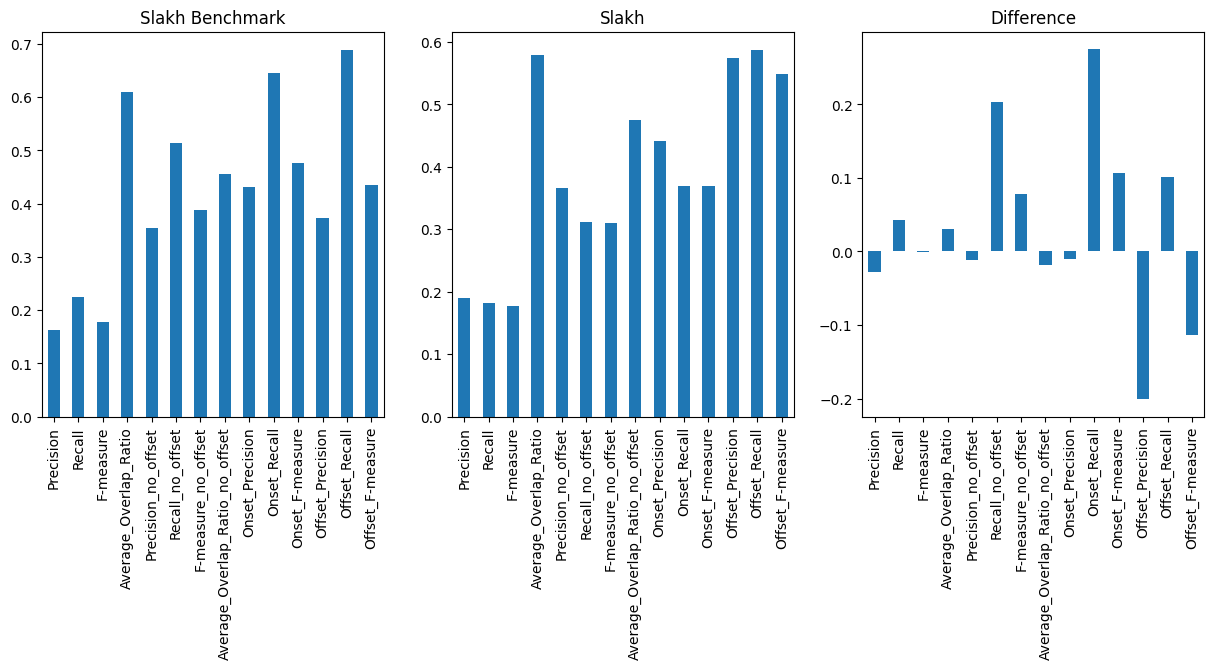

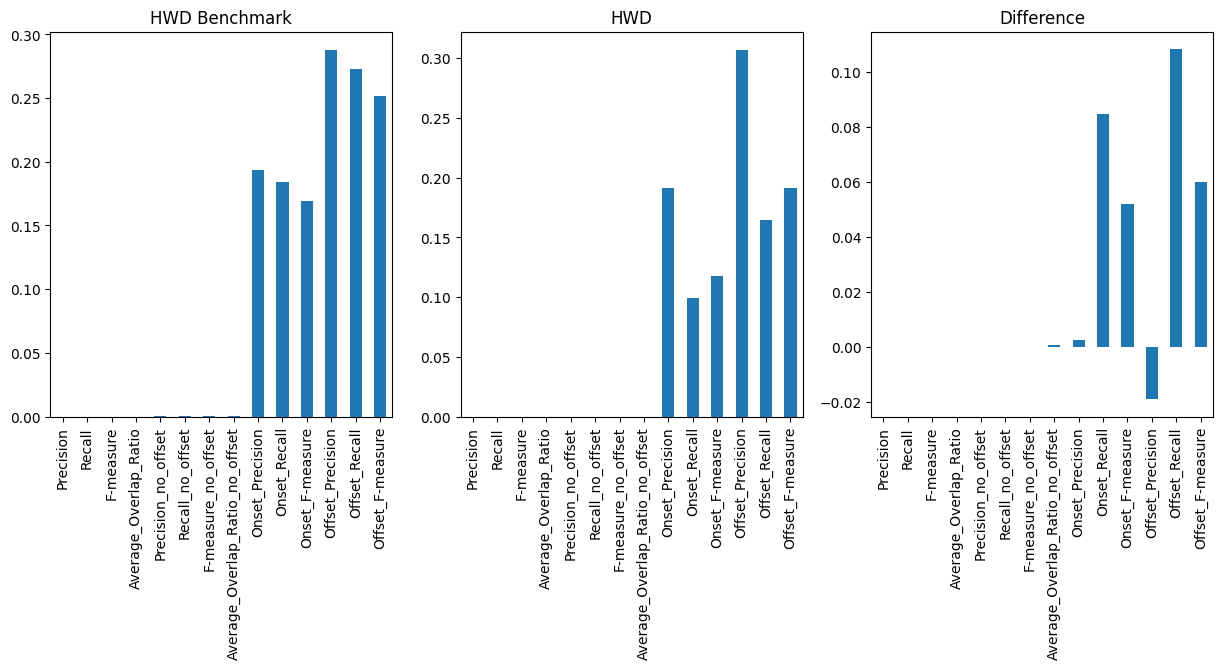

In [118]:
#plot comparison between guitarset and guitarset_b
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

guitarset_b.describe().loc['mean'].plot(kind='bar', ax=ax[0], title='GuitarSet Benchmark')
guitarset.describe().loc['mean'].plot(kind='bar', ax=ax[1], title='GuitarSet')
((guitarset_b).describe().loc['mean']-(guitarset).describe().loc['mean']).plot(kind='bar', ax=ax[2], title='Difference')

#plot comparison between slakh and slakh_b
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

slakh_b.describe().loc['mean'].plot(kind='bar', ax=ax[0], title='Slakh Benchmark')
slakh.describe().loc['mean'].plot(kind='bar', ax=ax[1], title='Slakh')
((slakh_b).describe().loc['mean']-(slakh).describe().loc['mean']).plot(kind='bar', ax=ax[2], title='Difference')

#plot comparison between hwd and hwd_b
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

hwd_b.describe().loc['mean'].plot(kind='bar', ax=ax[0], title='HWD Benchmark')
hwd.describe().loc['mean'].plot(kind='bar', ax=ax[1], title='HWD')
((hwd_b).describe().loc['mean']-(hwd).describe().loc['mean']).plot(kind='bar', ax=ax[2], title='Difference')

